In [304]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import regionmask
import pandas as pd
from geopy.geocoders import Nominatim
from matplotlib.colors import SymLogNorm
from matplotlib.pyplot import cm

import xesmf as xe
#from pykrige.ok import OrdinaryKriging
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import dask
import utils


import cartopy.feature
from cartopy.mpl.patch import geos_to_path
import cartopy.crs as ccrs

import geopandas

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import country mask

In [305]:
country_mask = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
country_df = geopandas.read_file('ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')

In [306]:
countries = ['China','Indonesia','Malaysia','Vietnam','Australia', 'Cambodia','Myanmar', 'Laos','Philippines','Nepal','Bangladesh','Thailand','Bhutan']

<GeoAxesSubplot:>

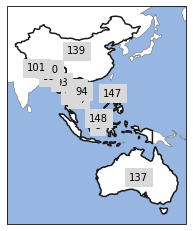

In [307]:
country_mask[countries].plot(add_ocean=True, )

## Open dataset

In [308]:
ds_poll = xr.open_dataset('Outputs/multi_country_early_shutdown_annual_means.nc4')

## Prep dataset with BC output

In [309]:
country_df = country_df.rename(columns = {'SOVEREIGNT':'country'})

In [310]:
for t in np.arange(0,len(ds_poll.year)):
    for c in countries:
        for y in ds_poll.year_shutdown.values:
            for p in ds_poll.percent.values:
                country_df.loc[country_df['country'] == c, f'BC_conc_{y}_{p}_{t}'] = ds_poll.where(ds_poll.country == c, drop = True).sel(year_shutdown = y, percent = p).isel(year = t)['BC_conc'].values[0]
                #country_df['pop_BC_per_mil'] = (country_df['BC_dif']/country_df['POP_EST'])*1e6

/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `f

## Mortality Calculations

In [311]:
def ppb_to_ug(ds, species_to_convert, mw_species_list, stp_p = 101325, stp_t = 298.):
    '''Convert species to ug/m3 from ppb'''
    R = 8.314 #J/K/mol
    ppb_ugm3 = (stp_p / stp_t / R) #Pa/K/(J/K/mol) = g/m^3

    for spec in species_to_convert:
        attrs = ds[spec].attrs
        ds[spec] = ds[spec]*mw_species_list[spec]*ppb_ugm3 #ppb*g/mol*g/m^3
        ds[spec].attrs['units'] = 'μg m-3'
    #return(ds)

mw_BC = {'BC_conc':12.011}

In [312]:
ds_base = xr.open_dataset(f'Outputs/C_out_{100}_{40}.nc')#('/net/fs03/d1/emfreese/BC-IRF/Outputs/Retirements/C_out_age_retirement_40.nc')

ds_base = ds_base.rename({'__xarray_dataarray_variable__':'BC_conc'})

ppb_to_ug(ds_base, ['BC_conc'], mw_BC)


In [313]:
country_mask = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
countries = ['China','Indonesia','Malaysia','Vietnam','Australia', 'Cambodia','Myanmar', 'Laos','Philippines','Nepal','Bangladesh','Thailand','Bhutan']
print('countries uploaded')

countries uploaded


In [314]:
ds_area = xr.open_dataset('/net/fs11/d0/emfreese/GCrundirs/IRF_runs/stretch_2x_pulse/SEA/Jan/mod_output/GEOSChem.SpeciesConc.20160101_0000z.nc4', engine = 'netcdf4')
ds_area = utils.fix_area_ij_latlon(ds_area)

In [315]:
mask = {}
contiguous_mask = {}
mask_ds = {}
for idx, c in enumerate(countries):
    mask[c] = country_mask.mask(ds_base, lon_name = 'lon', lat_name = 'lat')
    contiguous_mask[c] = ~np.isnan(mask[c] )& (mask[c]  == country_mask.map_keys(countries[idx] ))
    mask_ds[c] = ds_base.where(contiguous_mask[c]).weighted(ds_area['area']).mean(dim = ['lat','lon'])#.sum(dim = ['s'])
mask_full_base_ds = xr.concat([mask_ds[c] for c in countries], pd.Index([c for c in countries], name = 'country'))

In [316]:
RR = 1.02 #global mean
del_x = 10 #ug/m3
beta = np.log(RR)/del_x


# In[17]:

## 2019 mortalities to match 2019 population data
I_val = {}
I_val['China'] = 10462043.68
I_val['Indonesia'] = 35874.09
I_val['Malaysia'] = 169483.46
I_val['Vietnam'] = 606145.89
I_val['Australia'] = 169053.20
I_val['Cambodia'] = 96284.85
I_val['Myanmar'] = 368031.84
I_val['Laos'] = 35874.09
I_val['Philippines'] = 557809.29
I_val['Nepal'] = 170032.44
I_val['Bangladesh'] = 740684.73
I_val['Thailand'] = 486556.52
I_val['Bhutan'] = 3713.40


In [317]:
I_val_df = pd.DataFrame(I_val.values(), index = I_val.keys()).rename(columns = {0:'Ival'})

In [318]:
I_val_df.index.rename('country', inplace = True)

In [319]:
pop_df = country_df.loc[country_df['country'].isin(countries)].loc[country_df['POP_YEAR'] == 2019][['country','POP_EST']].set_index('country').groupby('country').max()

In [320]:
I0_pop_df = pd.merge(pop_df, I_val_df, left_index=True, right_index=True)

In [321]:
I0_pop_df['I_obs'] = I0_pop_df['Ival']/I0_pop_df['POP_EST']

In [322]:
years = pd.date_range(f"{int(ds_poll['year'].min())}-01-01", freq="D", periods=len(mask_full_base_ds['s']))

In [323]:
mask_full_base_ds['s'] = years

In [324]:
mask_annual_base_ds = mask_full_base_ds.groupby('s.year').mean()

In [325]:
for t in np.arange(0,len(ds_poll.year)):
        for y in [10,20,30]:
            for p in [100,60,10]:
                I0_pop_df[f'delta_I_{y}_{p}_{t}'] = np.nan

/tmp/ipykernel_3367814/405258849.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  I0_pop_df[f'delta_I_{y}_{p}_{t}'] = np.nan
/tmp/ipykernel_3367814/405258849.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  I0_pop_df[f'delta_I_{y}_{p}_{t}'] = np.nan
/tmp/ipykernel_3367814/405258849.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented

In [326]:
for t in np.arange(0,len(ds_poll.year)):
    for c in countries:
        for y in [10,20,30]:
            for p in [100,60,10]:
                AF = ((np.exp(beta*(country_df.loc[country_df['ADMIN'] == c][f'BC_conc_{y}_{p}_{t}']- 
                                                         mask_annual_base_ds.where(mask_annual_base_ds.country == c, drop = True).isel(year = t)['BC_conc'].values[0])) - 1)/
                                            np.exp(beta*(country_df.loc[country_df['ADMIN'] == c][f'BC_conc_{y}_{p}_{t}']- 
                                                         mask_annual_base_ds.where(mask_annual_base_ds.country == c, drop = True).isel(year = t)['BC_conc'].values[0])))
                #I0_pop_df[f'AF_{y}_{p}_{t}'] = np.nan
                #I0_pop_df.loc[c][f'AF_{y}_{p}_{t}'] = AF
                I0_pop_df.loc[c][f'delta_I_{y}_{p}_{t}'] = AF * I0_pop_df.loc[c]['POP_EST']*I0_pop_df.loc[c]['I_obs']
                if t > 0: 
                    t_min1 = t-1
                    I0_pop_df.loc[c][f'delta_I_{y}_{p}_{t}'] = I0_pop_df.loc[c][f'delta_I_{y}_{p}_{t_min1}'] + I0_pop_df.loc[c][f'delta_I_{y}_{p}_{t}']


In [327]:
y = 10
p = 90
t = 50

In [328]:
for t in np.arange(0,len(ds_poll.year)):
    for c in countries:
        for y in [10,20,30]:
            for p in [100,60,10]:
                country_df.loc[country_df['country'] == c, f'delta_I_{y}_{p}_{t}'] = I0_pop_df.loc[c][f'delta_I_{y}_{p}_{t}']
                #country_df['pop_BC_per_mil'] = (country_df['BC_dif']/country_df['POP_EST'])*1e6

/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `f

## Import Convolution for 20 years 60%

In [329]:
conv_ds = xr.open_dataset('Outputs/C_out_60_20.nc')
conv_ds = conv_ds.rename({'__xarray_dataarray_variable__':'BC_conc'})
conv_ds['BC_conc']*=1e9
conv_ds['BC_conc'].attrs = {'units':'ppb'}
ppb_to_ug(conv_ds, ['BC_conc'], mw_BC)

In [ ]:
(1e12*f0['SEA_Jan']*G.isel(time = slice(0,15), lev = -1)).sel(run = 'SEA_Jan').sum(dim = 'time').where(
    (G.isel(time = slice(0,15), lev = -1)).sum(dim = 'time').sel(run = 'SEA_Jan') > 1e-24)

## Combined concentration and mortality plot

In [430]:
for t in np.arange(0,50):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = [30,8], subplot_kw={'projection':ccrs.PlateCarree()})
    ##### global view #######
    p = (conv_ds.isel(s = t)['BC_conc'].where(conv_ds.isel(s = t)['BC_conc'] > 1e-4)).plot(ax = ax1, transform = ccrs.PlateCarree(), cbar_kwargs = {'label':''},
                                                                                norm = SymLogNorm(1e-4, 1, 0, 1e1), extend = 'max',
                                                                               cmap = 'Reds')
   
    ax1.coastlines()
    ax1.set_title('')
    fig.text(.62, .3, f'Black Carbon ($\mu$g/m$^3$)', fontsize = 20, rotation = 'vertical')
    ##### mortalities ########
    country_df[country_df['ADMIN'].isin(countries)].boundary.plot(ax = ax2, color = 'k', linewidth = .2)
    m = country_df.plot(ax = ax2, column = f'delta_I_20_60_{t}', legend = True, cmap = 'Reds',vmax = 4000, vmin = 100,
                            legend_kwds={"orientation": "vertical", "anchor":  (0.0, 1), 'fraction':0.1 })
    ax2.set_title('')
    plt.suptitle(f'{t+1} years', fontsize = 24);
    fig.text(.98, .12, f'Cumulative Additional Mortalities', fontsize = 20, rotation = 'vertical')
    plt.subplots_adjust(wspace=-0.6)
    plt.tight_layout()       
    plt.savefig("figures/conc_mort_video/" + str(t).zfill(4) + ".png", dpi = 350, bbox_inches = 'tight')
    plt.close();

## Plot

In [289]:
for t in np.arange(0,50):
    fig, axes = plt.subplots(len([10,20,30]), len([100,60,10]), figsize = [20,20], sharex = True, sharey = True)
    for idx_y, y in enumerate([10,20,30]):
        for idx_p, p in enumerate([100,60,10]):
            #print(t, 'sum of years')
            country_df[country_df['country'].isin(countries)].boundary.plot(ax = axes[idx_y,idx_p], color = 'k', linewidth = .2)
            if ((idx_p == 2) and (idx_y == 1)):
                m = country_df.plot(ax = axes[idx_y,idx_p], column = f'delta_I_{y}_{p}_{t}', legend = True, cmap = 'Reds',vmax = 4000, vmin = 100, 
                                    legend_kwds={"orientation": "vertical", "anchor":  (0.0, 1), 'fraction':0.1 })
                #leg = axes[idx_y,idx_p].get_legend()
                #leg.set_bbox_to_anchor((0., 0., 0.2, 0.2))
            else:
                m = country_df.plot(ax = axes[idx_y,idx_p], column = f'delta_I_{y}_{p}_{t}', cmap = 'Reds',vmax = 4000, vmin = 100)
            #ax = axes[idx_y,idx_p].set_title(f'{p}% shutdowns in year {y}')  
            axes[idx_y,0].set_ylabel(f'Year {y}', fontsize = 18);
            axes[0, idx_p].set_title(f'Top {p}% CO$_2$ Emitters Shutdown', fontsize = 18);
    #fig.subplots_adjust(right = .85)
    fig.text(1, .4, f'Cumulative Additional Mortalities, Year {t+1}', fontsize = 20, rotation = 'vertical')
    plt.tight_layout()       

    plt.savefig("figures/mort_video/" + str(t).zfill(4) + ".png", dpi = 350, bbox_inches = 'tight')
    plt.close();

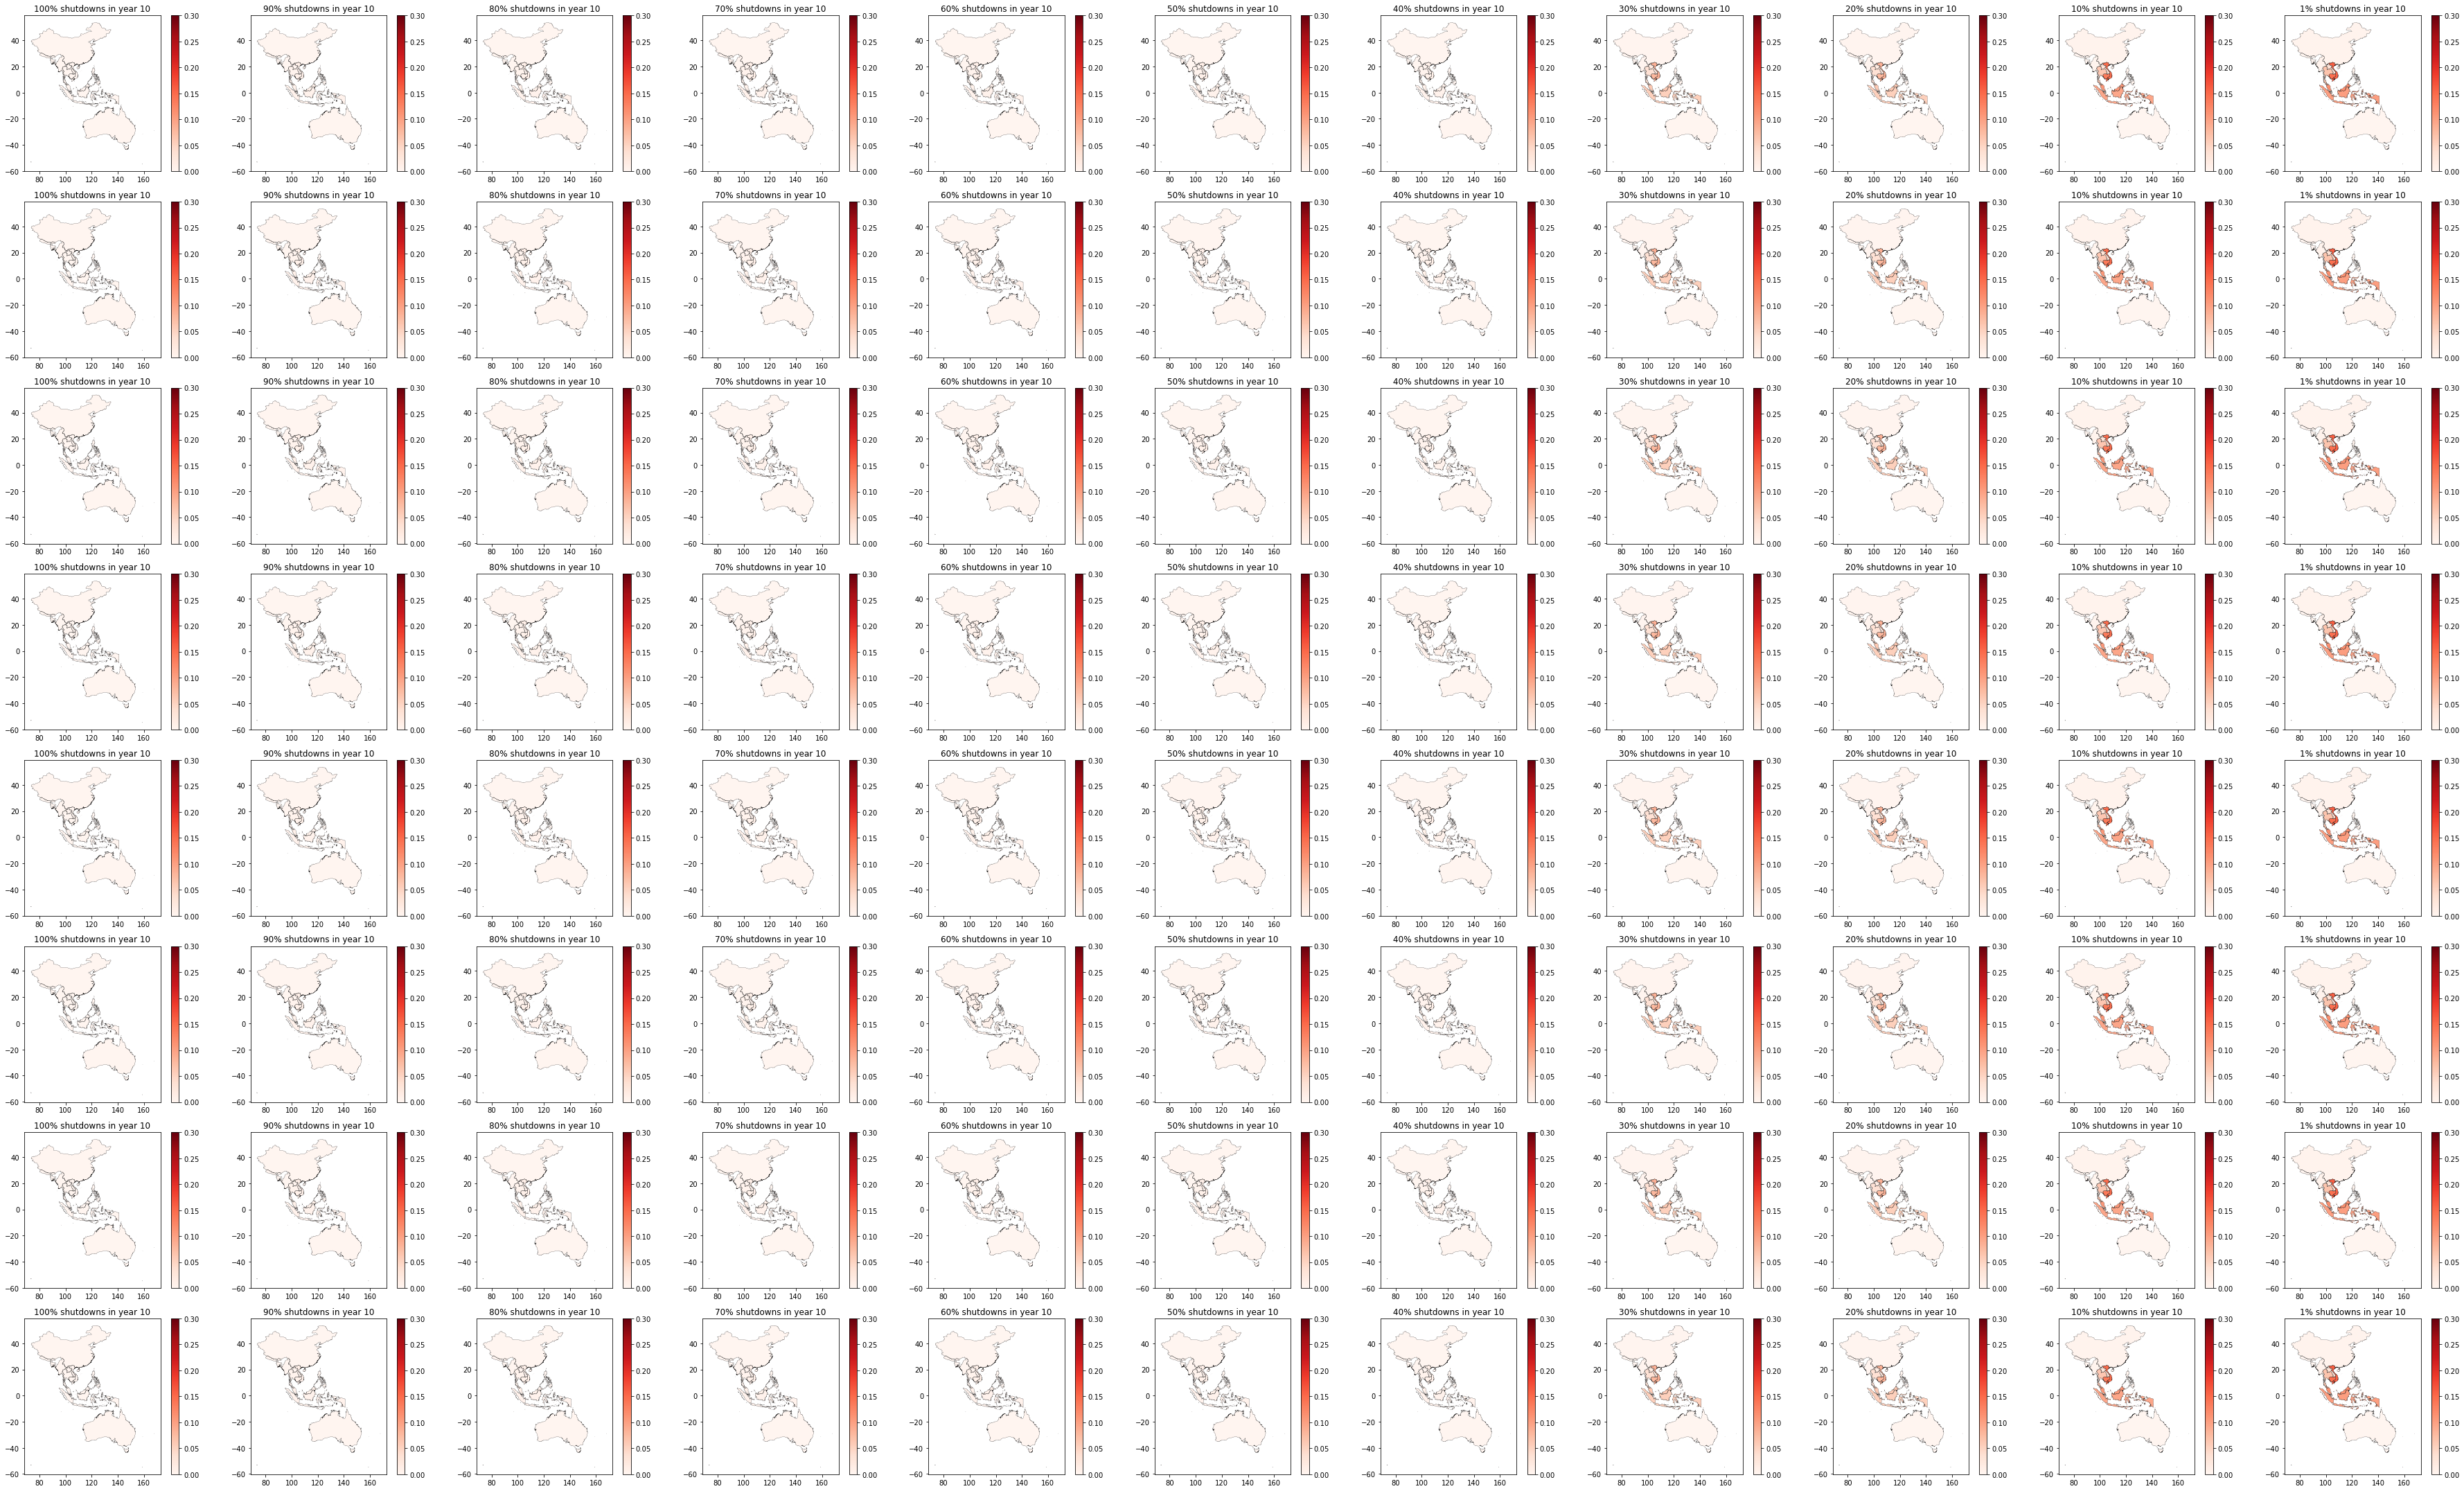

In [67]:
fig, axes = plt.subplots(len(ds_poll.year_shutdown), len(ds_poll.percent), figsize = [50,30])
for idx_y, y in enumerate(ds_poll.year_shutdown.values):
    for idx_p, p in enumerate(ds_poll.percent.values):
        country_df[country_df['country'].isin(countries)].boundary.plot(ax = axes[idx_y,idx_p], color = 'k', linewidth = .2)
        country_df.plot(ax = axes[idx_y,idx_p], column = f'BC_conc_{y}_{p}', cmap = 'Reds', legend = True, vmax = .3, vmin = 0)
        ax = axes[idx_y,idx_p].set_title(f'{p}% shutdowns in year {y}')  
plt.tight_layout()